In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import cv2
import pathlib
from tqdm import tqdm
import copy
from collections import OrderedDict
from typing import Tuple
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CMPT983/animals_dataset_0329.zip

In [ ]:
!unzip /content/drive/MyDrive/CMPT983/animal_test_87imgs.zip

In [ ]:
!unzip /content/drive/MyDrive/CMPT983/animals_train_732imgs.zip

In [ ]:
!rm -rf /content/animals_dataset_0329_1

In [ ]:
train_data_dir = '/content/animals_dataset_0309/training'
train_data_dir = pathlib.Path(train_data_dir)

test_data_dir = '/content/animals_dataset_0309/testing'
test_data_dir = pathlib.Path(test_data_dir)

In [ ]:
img_height,img_width=256,256
batch_size=32

data_augmentation = ImageDataGenerator(
    rotation_range=10,       # Random rotations
    width_shift_range=0.1,   # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,         # Shear transformations
    zoom_range=0.1,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Fill strategy
)

train_ds = data_augmentation.flow_from_directory(
    train_data_dir,                  # Make sure this points to your training data directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_dir,
#     label_mode='categorical',
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

Found 654 images belonging to 4 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 165 files belonging to 4 classes.


# Constructing the Model

In [ ]:
# ResNet

@keras.saving.register_keras_serializable(package="my_model")
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width, 3),
                   pooling='avg',classes=4,
                   weights='imagenet')
                  #  weights=None)
        for layer in self.pretrained_model.layers:
                layer.trainable=False
                # layer.trainable=True
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(512, activation="relu")
        self.dense2 = keras.layers.Dense(4, activation="softmax")
        # self.cnt = tf.Variable(0, trainable=False)
        # self.cnt_loss = tf.Variable(0, trainable=False)
        self.alpha = tf.Variable(0, trainable=False)
        self.shuffled_indices = tf.Variable([], trainable=False)
        self.flag = tf.Variable(0, trainable=False)
        # self.log_data = []

    def call(self, inputs, training=None):
        self.flag = 0
        x = self.pretrained_model(inputs)
        x = self.flatten(x)

        # manifold mixup
        if training:
          self.flag = 1
          # self.cnt.assign_add(1)
          self.alpha = tf.random.uniform(shape=[], minval=1, maxval=1)
          x_a = x
          indices = tf.range(tf.shape(x_a)[0])
          shuffled_indices = tf.random.shuffle(indices)
          self.shuffled_indices = shuffled_indices
          x_b = tf.gather(x_a, shuffled_indices)
          x = self.alpha * x_a + (1 - self.alpha) * x_b

          # Writing alpha and shuffled_indices to a text file
          # log_str = tf.strings.format("Alpha: {}, Shuffled Indices: {}\n", (self.alpha, shuffled_indices))
          # self.log_data.append(log_str.numpy().decode('utf-8'))
        # end of manifold mixup

        x = self.dense1(x)
        x = self.dense2(x)

        return x

    # def write_logs(self, filename="mixup_log.txt"):
    #     with open(filename, "w") as file:
    #         for log in self.log_data:
    #             file.write(log)
    #     self.log_data.clear()

resnet_model_1 = MyModel()
resnet_model_1.build((None, img_height, img_width, 3))

In [ ]:
!pip install vit-keras
!pip install tensorflow-addons==0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00


In [ ]:
# ViT

from vit_keras import vit
@keras.saving.register_keras_serializable(package="my_model")
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.vit = vit.vit_l32(
                  image_size=(img_height, img_width),
                  # activation='sigmoid',
                  pretrained=True,
                  include_top=False,
                  weights='imagenet21k',
                  pretrained_top=False
              )
        for layer in self.vit.layers:
                layer.trainable=False
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(512, activation="relu")
        self.dense2 = keras.layers.Dense(4, activation="softmax")

        self.alpha = tf.Variable(0, trainable=False)
        self.shuffled_indices = tf.Variable([], trainable=False)
        self.flag = tf.Variable(0, trainable=False)


    def call(self, inputs, training=None):
        self.flag = 0
        x = self.vit(inputs)
        x = self.flatten(x)

        # manifold mixup
        if training:
          self.flag = 1
          # self.cnt.assign_add(1)
          self.alpha = tf.random.uniform(shape=[], minval=0.85, maxval=1)
          x_a = x
          indices = tf.range(tf.shape(x_a)[0])
          shuffled_indices = tf.random.shuffle(indices)
          self.shuffled_indices = shuffled_indices
          x_b = tf.gather(x_a, shuffled_indices)
          x = self.alpha * x_a + (1 - self.alpha) * x_b

          # Writing alpha and shuffled_indices to a text file
          # log_str = tf.strings.format("Alpha: {}, Shuffled Indices: {}\n", (self.alpha, shuffled_indices))
          # self.log_data.append(log_str.numpy().decode('utf-8'))
        # end of manifold mixup

        x = self.dense1(x)
        x = self.dense2(x)

        return x

    # def write_logs(self, filename="mixup_log.txt"):
    #     with open(filename, "w") as file:
    #         for log in self.log_data:
    #             file.write(log)
    #     self.log_data.clear()

vit_model_1 = MyModel()
vit_model_1.build((None, img_height, img_width, 3))

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 7, 7 to 8, 8
  warnings.warn(


In [ ]:
resnet_model_1.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  1049088   
                                                                 
 dense_3 (Dense)             multiple                  2052      
                                                                 
Total params: 24638853 (93.99 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 23587713 (89.98 MB)
_________________________________________________________________


In [ ]:
vit_model_1.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              306575360 
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  524800    
                                                                 
 dense_1 (Dense)             multiple                  2052      
                                                                 
Total params: 307102213 (1.14 GB)
Trainable params: 526852 (2.01 MB)
Non-trainable params: 306575361 (1.14 GB)
_________________________________________________________________


# Loss Function

In [ ]:
@keras.saving.register_keras_serializable(package="my_loss", name="mixup_criterion")
def mixup_criterion(y_a, pred, criterion=tf.losses.CategoricalCrossentropy(),):
    # print(resnet_model_1.flag)
    # print(y_a)
    # print(pred)
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    # if resnet_model_1.flag%2 == 0:
    #     resnet_model_1.cnt_train.assign_add(1)
    # else:
    #     resnet_model_1.cnt_val.assign_add(1)

    # if resnet_model_1.cnt_train == len(train_ds) or resnet_model_1.cnt_val == len(val_ds):
    #     resnet_model_1.flag.assign_add(1)
    #     resnet_model_1.cnt_train.assign(0)
    #     resnet_model_1.cnt_val.assign(0)

    # resnet_model_1.cnt.assign_add(1)

    if resnet_model_1.flag == 1:
        # resnet_model_1.cnt_loss.assign_add(1)
        # tf.print(resnet_model_1.shuffled_indices)
        y_b = tf.gather(y_a, resnet_model_1.shuffled_indices)
        return resnet_model_1.alpha * criterion(y_a, pred) + (1 - resnet_model_1.alpha) * criterion(y_b, pred)
    else:
        return criterion(y_a, pred)


In [ ]:
@keras.saving.register_keras_serializable(package="my_loss", name="mixup_criterion")
def mixup_criterion(y_a, pred, criterion=tf.losses.CategoricalCrossentropy(),):
    # print(resnet_model_1.flag)
    # print(y_a)
    # print(pred)
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    # if resnet_model_1.flag%2 == 0:
    #     resnet_model_1.cnt_train.assign_add(1)
    # else:
    #     resnet_model_1.cnt_val.assign_add(1)

    # if resnet_model_1.cnt_train == len(train_ds) or resnet_model_1.cnt_val == len(val_ds):
    #     resnet_model_1.flag.assign_add(1)
    #     resnet_model_1.cnt_train.assign(0)
    #     resnet_model_1.cnt_val.assign(0)

    # resnet_model_1.cnt.assign_add(1)

    if vit_model_1.flag == 1:
        # resnet_model_1.cnt_loss.assign_add(1)
        # tf.print(resnet_model_1.shuffled_indices)
        y_b = tf.gather(y_a, vit_model_1.shuffled_indices)
        return vit_model_1.alpha * criterion(y_a, pred) + (1 - vit_model_1.alpha) * criterion(y_b, pred)
    else:
        return criterion(y_a, pred)

# Train the model without transfer learning

In [ ]:
# ResNet
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 13s 444ms/step - loss: 0.1360 - accuracy: 0.9511 - val_loss: 0.5961 - val_accuracy: 0.8667
Epoch 2/30
21/21 [==============================] - 9s 403ms/step - loss: 0.0715 - accuracy: 0.9679 - val_loss: 0.6521 - val_accuracy: 0.8364
Epoch 3/30
21/21 [==============================] - 8s 402ms/step - loss: 0.0392 - accuracy: 0.9847 - val_loss: 0.5088 - val_accuracy: 0.8606
Epoch 4/30
21/21 [==============================] - 9s 412ms/step - loss: 0.0257 - accuracy: 0.9908 - val_loss: 0.5020 - val_accuracy: 0.8727
Epoch 5/30
 2/21 [=>............................] - ETA: 7s - loss: 0.0178 - accuracy: 1.0000

KeyboardInterrupt: 

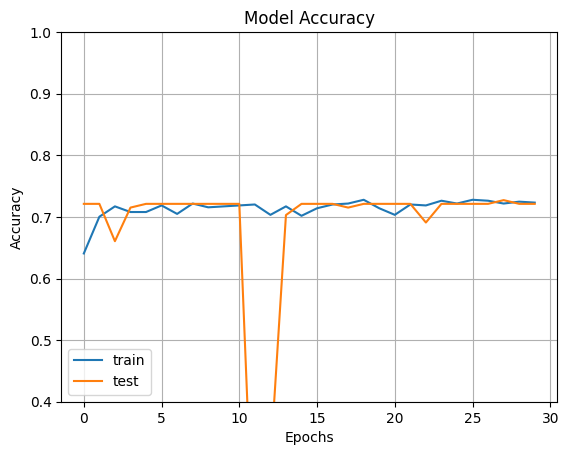

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
# ViT
num_epochs = 30

vit_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

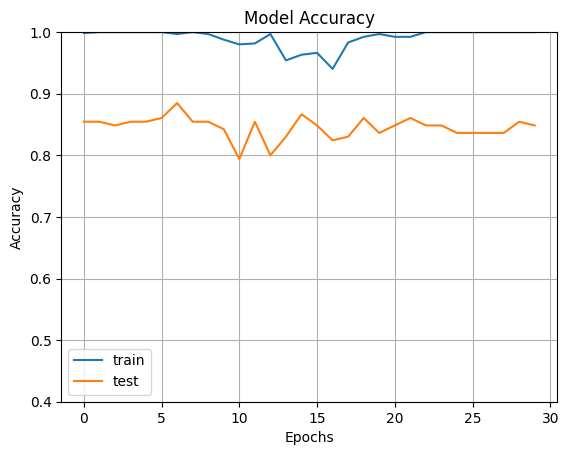

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Train the Model with Transfer Learning

In [ ]:
# ViT
num_epochs = 30

vit_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history = vit_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

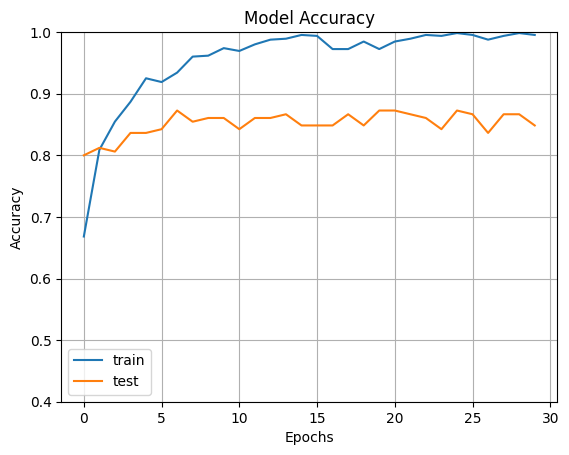

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history_1 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

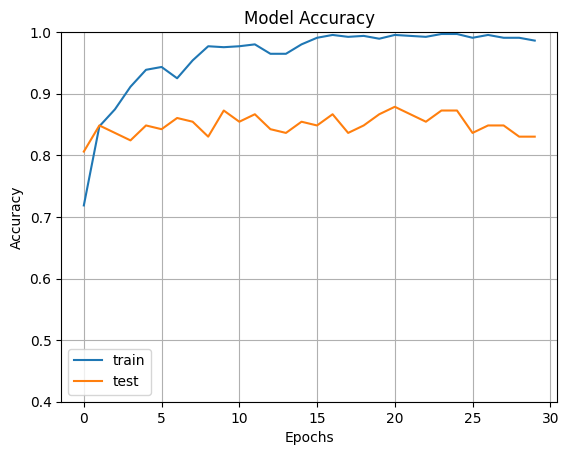

In [ ]:
fig1 = plt.gcf()
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history_2 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

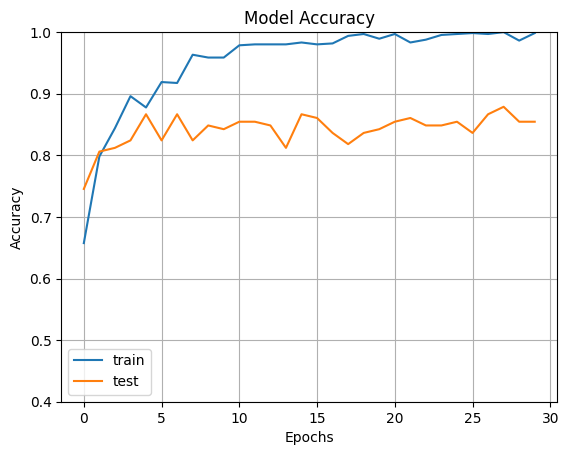

In [ ]:
fig1 = plt.gcf()
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Train the Model with Transfer Learning + Manifold Mixup

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

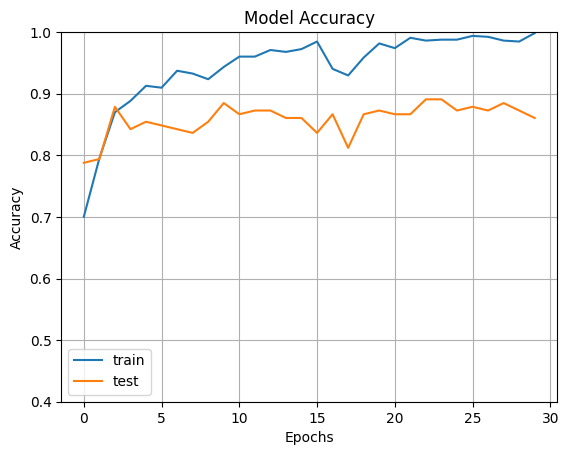

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history.history['accuracy'])
plt.plot(mixup_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_1 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

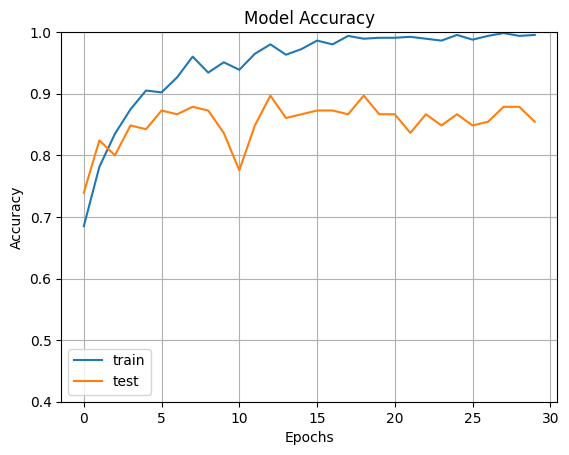

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_1.history['accuracy'])
plt.plot(mixup_history_1.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_2 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

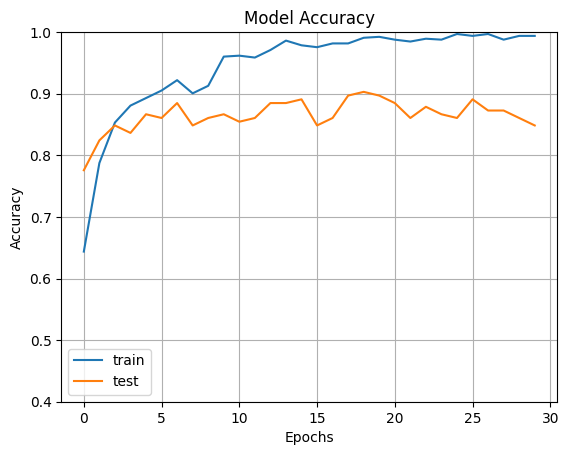

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_2.history['accuracy'])
plt.plot(mixup_history_2.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_test = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

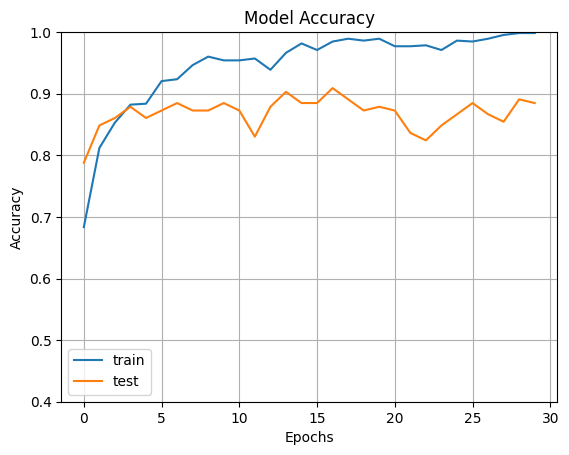

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_test.history['accuracy'])
plt.plot(mixup_history_test.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Train the Model with Transfer Learning + Synthetic data

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
synthetic_history_test = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
synthetic_history_test = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

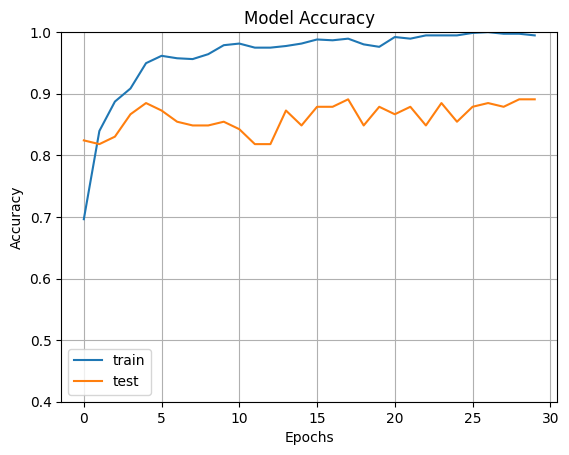

In [ ]:
fig1 = plt.gcf()
plt.plot(synthetic_history_test.history['accuracy'])
plt.plot(synthetic_history_test.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
synthetic_history_test = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

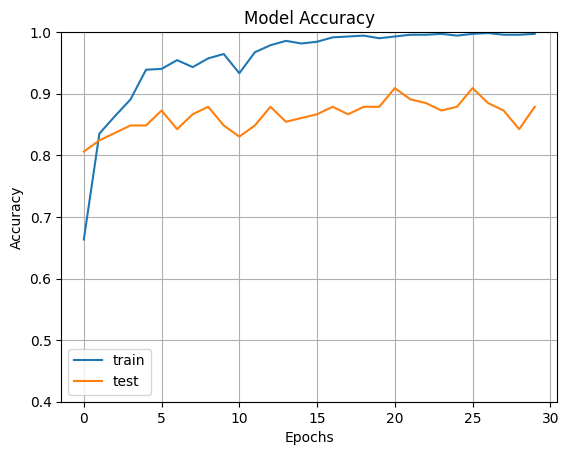

In [ ]:
fig1 = plt.gcf()
plt.plot(synthetic_history_test.history['accuracy'])
plt.plot(synthetic_history_test.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Save Model

In [ ]:
resnet_model_1.save('/content/drive/MyDrive/CMPT983/model_vit_transfer.keras')

In [ ]:
vit_model_1.save('/content/drive/MyDrive/CMPT983/model_vit_transfer.keras')

# Load Model

In [ ]:
@keras.saving.register_keras_serializable(package="my_model")
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width, 3),
                   pooling='avg',classes=4,
                   weights='imagenet')
        for layer in self.pretrained_model.layers:
                layer.trainable=False
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(512, activation="relu")
        self.dense2 = keras.layers.Dense(4, activation="softmax")
        self.flag = tf.Variable(0, trainable=False)

    def call(self, inputs, training=None):
        self.flag = 0
        x = self.pretrained_model(inputs)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
@keras.saving.register_keras_serializable(package="my_loss", name="mixup_criterion")
def mixup_criterion(y_a, pred, criterion=tf.losses.CategoricalCrossentropy(),):
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    return criterion(y_a, pred)

In [ ]:
model = MyModel()
model = keras.models.load_model('/content/drive/MyDrive/CMPT983/model_vit_transfer.keras')

# Evaluate Model

In [ ]:
loss, accuracy = resnet_model_1.evaluate(val_ds)
print(f"Loss:      {loss:.4f}")
print(f"Accuracy:  {accuracy*100:.4f}%")

6/6 [==============================] - 0s 38ms/step - loss: 0.5285 - accuracy: 0.8727
Loss:      0.5285
Accuracy:  87.2727%


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Get class names from the dataset
class_names = val_ds.class_names

# Make predictions
y_pred = []
y_true = []
for batch in val_ds:
    x, y = batch
    preds = resnet_model_1.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print the per-class accuracy with class names
for i, accuracy in enumerate(per_class_accuracy):
    print(f"Accuracy for {class_names[i]}: {accuracy*100:.2f}%")

1/1 [==============================] - 1s 859ms/step
Accuracy for lie: 60.00%
Accuracy for run: 62.50%
Accuracy for sit: 87.50%
Accuracy for walk:stand: 93.44%


In [ ]:
# from scratch
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get class names from the dataset
class_names = val_ds.class_names

# Make predictions
y_pred = []
y_true = []
for batch in val_ds:
    x, y = batch
    preds = resnet_model_1.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Calculate precision and recall for each class
precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision: TP / (TP + FP)
recall = np.diag(cm) / np.sum(cm, axis=1)     # Recall: TP / (TP + FN)

# Print the accuracy, precision, and recall for each class
for i, (acc, prec, rec) in enumerate(zip(per_class_accuracy, precision, recall)):
    print(f"Accuracy for {class_names[i]}: {acc*100:.2f}%")
    print(f"Precision for {class_names[i]}: {prec*100:.2f}%")
    print(f"Recall for {class_names[i]}: {rec*100:.2f}%")
    print("----------------------------")

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1_score = f1_score(y_true, y_pred, average='macro')

# Print overall metrics
print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Overall Precision: {overall_precision*100:.2f}%")
print(f"Overall Recall: {overall_recall*100:.2f}%")
print(f"Overall F1 Score: {overall_f1_score*100:.2f}%")


1/1 [==============================] - 1s 882ms/step
Accuracy for lie: 0.00%
Precision for lie: nan%
Recall for lie: 0.00%
----------------------------
Accuracy for run: 0.00%
Precision for run: nan%
Recall for run: 0.00%
----------------------------
Accuracy for sit: 0.00%
Precision for sit: nan%
Recall for sit: 0.00%
----------------------------
Accuracy for walk:stand: 100.00%
Precision for walk:stand: 70.11%
Recall for walk:stand: 100.00%
----------------------------

Overall Accuracy: 70.11%
Overall Precision: 17.53%
Overall Recall: 25.00%
Overall F1 Score: 20.61%


<ipython-input-30-b874f30e9bd2>:25: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision: TP / (TP + FP)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# transfer Learning
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get class names from the dataset
class_names = val_ds.class_names

# Make predictions
y_pred = []
y_true = []
for batch in val_ds:
    x, y = batch
    preds = resnet_model_1.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Calculate precision and recall for each class
precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision: TP / (TP + FP)
recall = np.diag(cm) / np.sum(cm, axis=1)     # Recall: TP / (TP + FN)

# Print the accuracy, precision, and recall for each class
for i, (acc, prec, rec) in enumerate(zip(per_class_accuracy, precision, recall)):
    print(f"Accuracy for {class_names[i]}: {acc*100:.2f}%")
    print(f"Precision for {class_names[i]}: {prec*100:.2f}%")
    print(f"Recall for {class_names[i]}: {rec*100:.2f}%")
    print("----------------------------")

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1_score = f1_score(y_true, y_pred, average='macro')

# Print overall metrics
print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Overall Precision: {overall_precision*100:.2f}%")
print(f"Overall Recall: {overall_recall*100:.2f}%")
print(f"Overall F1 Score: {overall_f1_score*100:.2f}%")


1/1 [==============================] - 0s 30ms/step
Accuracy for lie: 60.00%
Precision for lie: 75.00%
Recall for lie: 60.00%
----------------------------
Accuracy for run: 62.50%
Precision for run: 83.33%
Recall for run: 62.50%
----------------------------
Accuracy for sit: 87.50%
Precision for sit: 58.33%
Recall for sit: 87.50%
----------------------------
Accuracy for walk:stand: 93.44%
Precision for walk:stand: 93.44%
Recall for walk:stand: 93.44%
----------------------------

Overall Accuracy: 86.21%
Overall Precision: 77.53%
Overall Recall: 75.86%
Overall F1 Score: 75.38%


In [ ]:
# manifold mixup
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get class names from the dataset
class_names = val_ds.class_names

# Make predictions
y_pred = []
y_true = []
for batch in val_ds:
    x, y = batch
    preds = resnet_model_1.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Calculate precision and recall for each class
precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision: TP / (TP + FP)
recall = np.diag(cm) / np.sum(cm, axis=1)     # Recall: TP / (TP + FN)

# Print the accuracy, precision, and recall for each class
for i, (acc, prec, rec) in enumerate(zip(per_class_accuracy, precision, recall)):
    print(f"Accuracy for {class_names[i]}: {acc*100:.2f}%")
    print(f"Precision for {class_names[i]}: {prec*100:.2f}%")
    print(f"Recall for {class_names[i]}: {rec*100:.2f}%")
    print("----------------------------")

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1_score = f1_score(y_true, y_pred, average='macro')

# Print overall metrics
print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Overall Precision: {overall_precision*100:.2f}%")
print(f"Overall Recall: {overall_recall*100:.2f}%")
print(f"Overall F1 Score: {overall_f1_score*100:.2f}%")


1/1 [==============================] - 1s 902ms/step
Accuracy for lie: 88.89%
Precision for lie: 88.89%
Recall for lie: 88.89%
----------------------------
Accuracy for run: 57.14%
Precision for run: 88.89%
Recall for run: 57.14%
----------------------------
Accuracy for sit: 64.29%
Precision for sit: 60.00%
Recall for sit: 64.29%
----------------------------
Accuracy for walk_stand: 96.64%
Precision for walk_stand: 93.50%
Recall for walk_stand: 96.64%
----------------------------

Overall Accuracy: 89.70%
Overall Precision: 82.82%
Overall Recall: 76.74%
Overall F1 Score: 78.89%


In [ ]:
# synthetic data
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get class names from the dataset
class_names = val_ds.class_names

# Make predictions
y_pred = []
y_true = []
for batch in val_ds:
    x, y = batch
    preds = resnet_model_1.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Calculate precision and recall for each class
precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision: TP / (TP + FP)
recall = np.diag(cm) / np.sum(cm, axis=1)     # Recall: TP / (TP + FN)

# Print the accuracy, precision, and recall for each class
for i, (acc, prec, rec) in enumerate(zip(per_class_accuracy, precision, recall)):
    print(f"Accuracy for {class_names[i]}: {acc*100:.2f}%")
    print(f"Precision for {class_names[i]}: {prec*100:.2f}%")
    print(f"Recall for {class_names[i]}: {rec*100:.2f}%")
    print("----------------------------")

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1_score = f1_score(y_true, y_pred, average='macro')

# Print overall metrics
print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Overall Precision: {overall_precision*100:.2f}%")
print(f"Overall Recall: {overall_recall*100:.2f}%")
print(f"Overall F1 Score: {overall_f1_score*100:.2f}%")


1/1 [==============================] - 1s 930ms/step
Accuracy for lie: 88.89%
Precision for lie: 69.57%
Recall for lie: 88.89%
----------------------------
Accuracy for run: 64.29%
Precision for run: 69.23%
Recall for run: 64.29%
----------------------------
Accuracy for sit: 71.43%
Precision for sit: 66.67%
Recall for sit: 71.43%
----------------------------
Accuracy for walk_stand: 91.60%
Precision for walk_stand: 95.61%
Recall for walk_stand: 91.60%
----------------------------

Overall Accuracy: 87.27%
Overall Precision: 75.27%
Overall Recall: 79.05%
Overall F1 Score: 76.81%
